<a href="https://colab.research.google.com/github/FatemehRajabi/gold-usd-prediction/blob/main/gold_price_lstm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance scikit-learn


 Step 1: Load and Preprocess Forex Data (Gold)
 <br />
In this step, I collected historical price data for the Gold ETF (GLD) from Yahoo Finance using the yfinance library. The data includes key market indicators such as Open, High, Low, Close, and Volume, starting from January 1, 2015 to today's date. I then cleaned the data by keeping only the relevant columns and dropping any rows with missing values to ensure high-quality input for our model.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Get today's date
today = datetime.date.today()

# Load Gold ETF (GLD) data from Yahoo Finance
data = yf.download('GLD', start='2015-01-01', end=today)

# Flatten MultiIndex
data.columns = data.columns.get_level_values(0)
data.columns.name = None

# Keep only relevant columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,112.489998,114.800003,112.320000,114.080002,7109600
2015-01-05,114.779999,116.000000,114.730003,115.800003,8177400
2015-01-06,116.220001,117.500000,115.800003,117.120003,11238300
2015-01-07,116.470001,116.879997,116.169998,116.430000,6434200
2015-01-08,116.449997,116.870003,115.849998,115.940002,7033700


Step 2: Feature Engineering with Technical Indicators
To enrich my dataset with more informative features, I added a few commonly used technical indicators:

*  Simple Moving Average (SMA):
I calculated the 10-day and 30-day SMAs to capture short- and medium-term price trends.
*  Relative Strength Index (RSI):
I included the 14-day RSI to measure the strength and momentum of price movements, helping to identify potential overbought or oversold conditions.

After computing these indicators, I removed any rows with missing values to ensure the data remains clean and consistent for the modeling phase.

In [3]:
# Simple Moving Averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Drop rows with NaNs from indicators
data.dropna(inplace=True)

data.head()

,Open,High,Low,Close,Volume,SMA_10,SMA_30,RSI_14
Date,,,,,,,,
2015-02-13,118.050003,118.580002,117.790001,117.980003,4108900,119.551000,120.106667,35.742753
2015-02-17,116.400002,116.540001,115.580002,116.010002,7225200,118.910001,120.171001,26.861544
2015-02-18,115.989998,116.529999,114.989998,116.339996,8336000,118.439000,120.189000,29.748256
2015-02-19,116.400002,116.540001,115.739998,115.940002,6528700,117.875000,120.149667,34.165550
2015-02-20,116.099998,116.459999,115.050003,115.279999,6681700,117.224000,120.111334,19.029545


Step 3: Feature Normalization

Before feeding the data into a machine learning model, I normalized all feature values using MinMaxScaler from sklearn. This technique scales each feature to a range between 0 and 1, which helps improve model performance and training stability, especially for neural networks. Normalization also ensures that features with larger ranges do not dominate those with smaller ranges.

In [4]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print("Scaled shape:", scaled_data.shape)

Scaled shape: (2552, 8)


To train the LSTM model, we need to transform our time series data into sequences. In this step, I use a sliding window approach where each input sample consists of 60 timesteps (e.g., 60 days of data), including all 8 features. The corresponding label for each sample is the Close price on the next day.

This setup helps the model learn patterns and dependencies from the past 60 days to predict the Close price of the next day.

In [5]:
# Create sequences (60 timesteps back)
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # shape: (60, 8)
    y.append(scaled_data[i, 3])  # predict the Close price (index 3)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 60, 8)
print("y shape:", y.shape)  # (samples,)

X shape: (2492, 60, 8)
y shape: (2492,)


I split the data into 80% for training and 20% for testing. Since this is time series data, I didn't shuffle it. this way, the model learns from the past and gets tested on future data, just like how it would work in real life.

In [6]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

I created a Sequential model using TensorFlow and Keras. The model includes:

Two LSTM layers to help the model learn patterns from sequences of data.

Dropout layers after each LSTM to reduce overfitting by randomly turning off some neurons during training.

A Dense layer at the end to output a single value — the predicted closing price.

Finally, I compiled the model using the Adam optimizer and Mean Squared Error as the loss function since I’m working on a regression problem.

The summary shows the structure of the model and how many parameters it has.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Predicting one value: the Close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

I trained the model using the fit() function. I set it to train for 30 epochs with a batch size of 32. This means the model goes through the entire training data 30 times, and during each epoch, it updates weights after seeing 32 samples at a time.

I also included validation data (X_test and y_test) so I can monitor how well the model performs on unseen data while it’s training. The verbose=1 just means I can see the progress in the output while training.

The training results are stored in the history variable so I can later visualize the training and validation loss.

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.5215e-04 - val_loss: 0.0022
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1781e-04 - val_loss: 0.0032
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1548e-04 - val_loss: 0.0024
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.1562e-04 - val_loss: 0.0026
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.5644e-04 - val_loss: 0.0044
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.1692e-04 - val_loss: 0.0034
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.9221e-04 - val_loss: 0.0023
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3845e-04 - val_loss: 0.0024
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7805e-04 - val_loss: 0.0032
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9393e-04 - val_loss: 0.0046
Epoch 12/30
63/63 ━━━━━

I plotted the training loss and validation loss over each epoch to see how the model performed during training. A decreasing loss usually means the model is learning well.

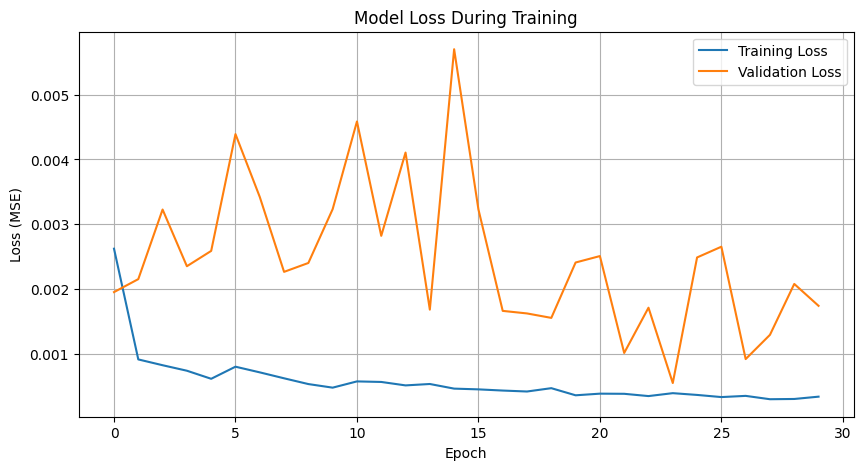

In [9]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


After training the model, I used it to make predictions on the test data. Since the model was trained on scaled values, the predicted results are also in that scaled format. To better understand the actual prices, I reversed the normalization process.

I specifically focused on the 'Close' price (which is at index 3 in my dataset), so I used the corresponding scale and minimum value that were applied during the normalization. This helped me convert both the predicted and actual values back to their original price range.

In [10]:
predicted = model.predict(X_test)

# Reverse normalization for 'Close' price only
close_scaler = scaler.scale_[3]
close_min = scaler.min_[3]

predicted_close = predicted / close_scaler + close_min
actual_close = y_test / close_scaler + close_min


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In this plot, I compared the predicted gold prices with the actual prices from the test set. This helps me understand how well my model is performing.

The blue line shows the actual Close prices.

The orange line shows the predicted Close prices by my LSTM model.

If the two lines are close to each other, it means the model is doing a good job at predicting future prices. Small gaps are expected, but big gaps can suggest the model still needs improvement.

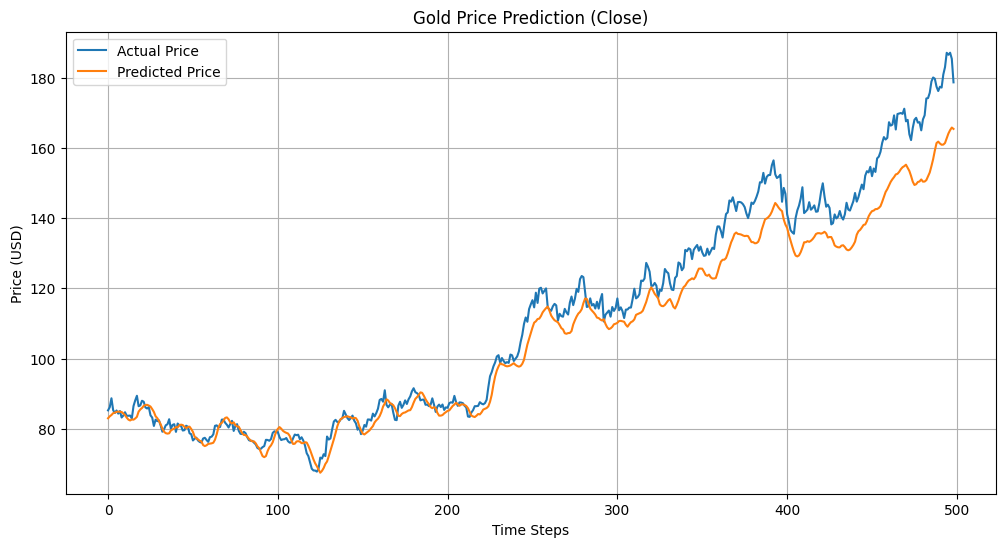

In [11]:
# Plot predicted vs actual Close prices
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Price')
plt.plot(predicted_close, label='Predicted Price')
plt.title('Gold Price Prediction (Close)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In this plot, I compared the actual gold prices (blue line) with the predicted prices (orange line) on the test set.

The model was able to follow the general trend of the gold prices, especially in the earlier and middle sections.

However, near the end of the time series, the predicted prices start to lag behind the actual prices. This shows that while the model captures the trend, it may need improvement for more accurate long-term forecasting.

Overall, the prediction performance looks reasonable, and this visualization helped me see where the model is performing well and where it can be improved.

To evaluate my model’s performance in numbers, I calculated two common error metrics:

RMSE (Root Mean Squared Error): This shows how far my predicted values are from the actual values on average, and it gives more weight to larger errors.

MAE (Mean Absolute Error): This gives the average size of the errors without squaring them, so it's easier to interpret.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Root Mean Squared Error (RMSE): 7.83620660569216
Mean Absolute Error (MAE): 5.714199843710891


In this part of my project, I tried different combinations of model hyperparameters to find which ones give the best prediction results. I used a grid search method, which means I checked every possible combination of selected parameters.

In [13]:
from tensorflow.keras import regularizers
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers import Adam

param_grid = {
    'units': [50, 100],
    'dropout': [0.2, 0.3],
    'l2_reg': [0.01, 0.001],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32],
    'epochs': [10]
}

results = []

for params in ParameterGrid(param_grid):
    model = Sequential()
    model.add(LSTM(units=params['units'], return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_regularizer=regularizers.l2(params['l2_reg'])))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(units=params['units'],
                   kernel_regularizer=regularizers.l2(params['l2_reg'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    history = model.fit(X_train, y_train,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        verbose=0,
                        validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Params: {params} -> MSE: {mse}")
    results.append((params, mse))

# Show top 3 configurations
results.sort(key=lambda x: x[1])
print("Top 3 configs:")
for i in range(3):
    print(results[i])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.001, 'units': 50} -> MSE: 0.016243883192378124


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.001, 'units': 100} -> MSE: 0.020006332727269458


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.0005, 'units': 50} -> MSE: 0.01879976794045433


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.0005, 'units': 100} -> MSE: 0.007391436618661891


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.001, 'units': 50} -> MSE: 0.0018547474021973754


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.001, 'units': 100} -> MSE: 0.003842697478627491


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.0005, 'units': 50} -> MSE: 0.003749102816246335


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.0005, 'units': 100} -> MSE: 0.000990644110173735


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.001, 'units': 50} -> MSE: 0.024189944989322254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.001, 'units': 100} -> MSE: 0.022994065919923815


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.0005, 'units': 50} -> MSE: 0.02685742066543314


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.01, 'learning_rate': 0.0005, 'units': 100} -> MSE: 0.014198942697497875


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.001, 'units': 50} -> MSE: 0.01008402512760319


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.001, 'units': 100} -> MSE: 0.004775051076304703


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.0005, 'units': 50} -> MSE: 0.003725740766827025


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Params: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.0005, 'units': 100} -> MSE: 0.002628129670470582
Top 3 configs:
({'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.0005, 'units': 100}, 0.000990644110173735)
({'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.001, 'units': 50}, 0.0018547474021973754)
({'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'l2_reg': 0.001, 'learning_rate': 0.0005, 'units': 100}, 0.002628129670470582)


After testing different combinations of hyperparameters using grid search, I found the top 3 configurations that gave the lowest Mean Squared Error (MSE) on the test data.
So I tried these hyperparameters for my model in the following codes:

In [29]:

# Define the best parameters
best_params = {
    'units': 100,
    'dropout': 0.2,
    'l2_reg': 0.001,
    'learning_rate': 0.0005,
    'batch_size': 32,
    'epochs': 10
}

# Build the model
model = Sequential()
model.add(LSTM(units=best_params['units'], return_sequences=True,
               kernel_regularizer=regularizers.l2(best_params['l2_reg']),
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(best_params['dropout']))
model.add(LSTM(units=best_params['units'],
               kernel_regularizer=regularizers.l2(best_params['l2_reg'])))
model.add(Dropout(best_params['dropout']))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1577 - val_loss: 0.0897
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0744 - val_loss: 0.0452
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0372 - val_loss: 0.0290
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0202 - val_loss: 0.0141
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0096
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029 - val_loss: 0.0062


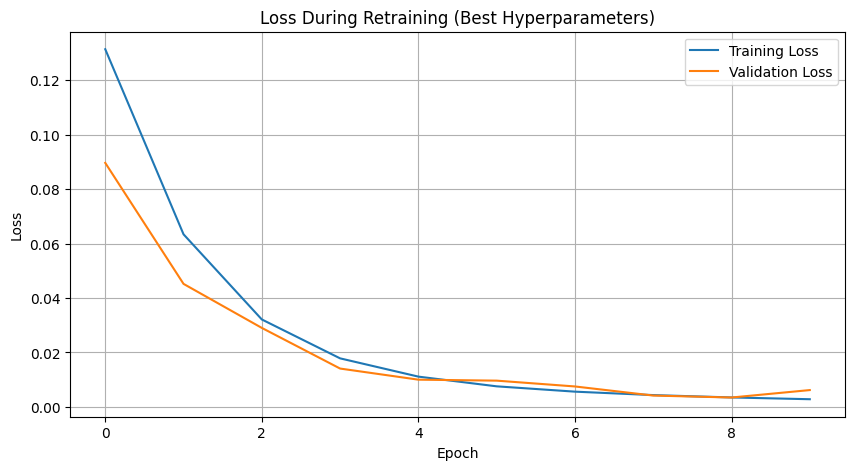

In [30]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Retraining (Best Hyperparameters)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Predict
predicted = model.predict(X_test)

# Reverse normalization for the 'Close' price
close_scaler = scaler.scale_[3]
close_min = scaler.min_[3]

predicted_close = predicted / close_scaler + close_min
actual_close = y_test / close_scaler + close_min


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


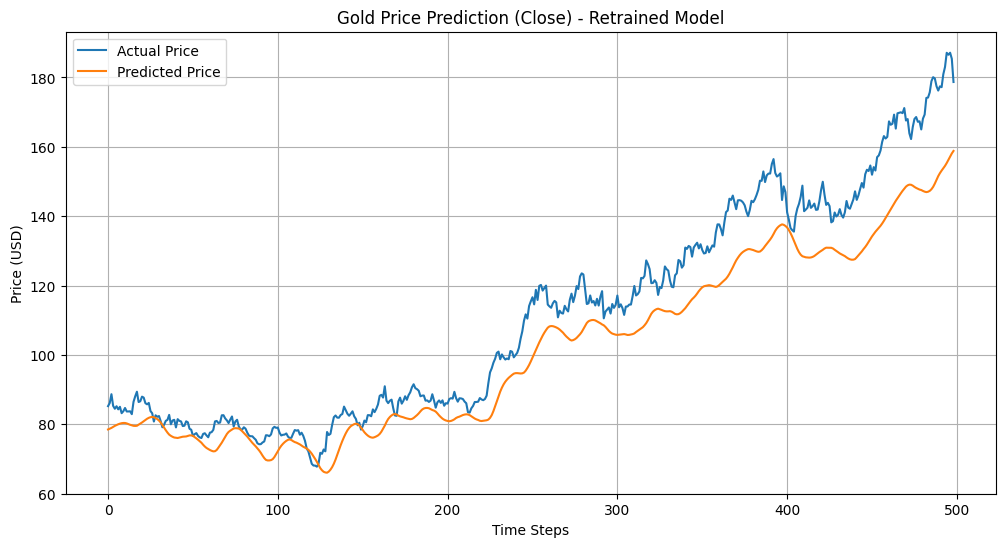

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Price')
plt.plot(predicted_close, label='Predicted Price')
plt.title('Gold Price Prediction (Close) - Retrained Model')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [33]:

rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Root Mean Squared Error (RMSE): 12.071560157274625
Mean Absolute Error (MAE): 9.829149282757841


In [19]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True,
         kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    LSTM(100, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 60, 100)             │          43,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,101 (484.77 KB)

 Trainable params: 124,101 (484.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1376 - val_loss: 0.0492
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0344 - val_loss: 0.0174
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0138 - val_loss: 0.0091
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0087
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

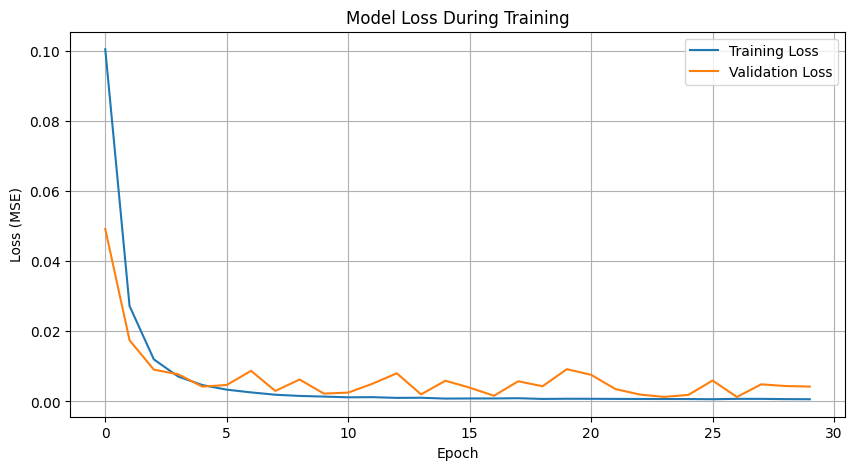

In [20]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
predicted = model.predict(X_test)

# Reverse normalization for 'Close' price only
close_scaler = scaler.scale_[3]
close_min = scaler.min_[3]

predicted_close = predicted / close_scaler + close_min
actual_close = y_test / close_scaler + close_min


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


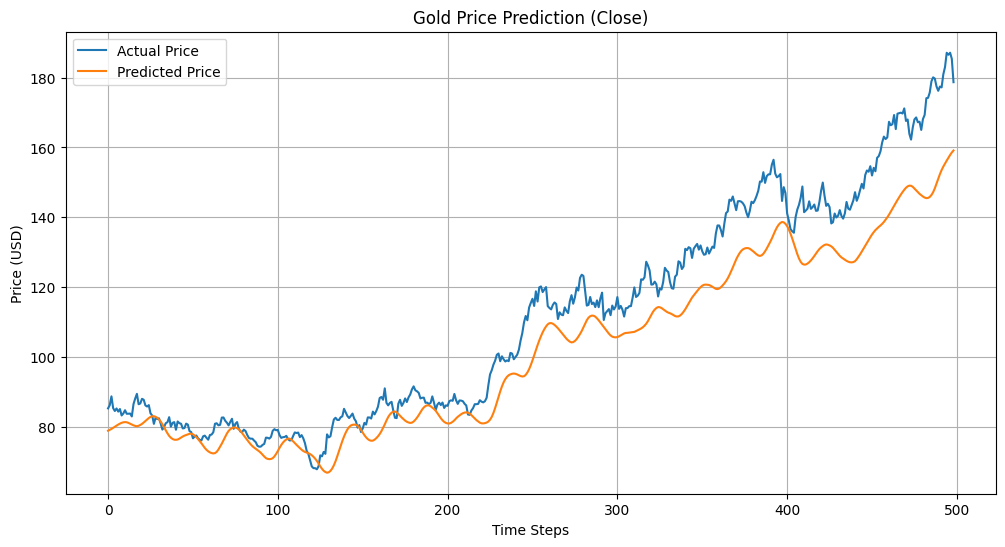

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Price')
plt.plot(predicted_close, label='Predicted Price')
plt.title('Gold Price Prediction (Close)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Root Mean Squared Error (RMSE): 11.9559
Mean Absolute Error (MAE): 9.5125


I wasn’t fully satisfied with the results from my earlier models, even after using grid search. So, I decided to try one more approach to improve the performance of the model by adding two important callbacks:

- EarlyStopping

EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

This callback monitors the validation loss during training. If the loss doesn’t improve for 5 consecutive epochs, it stops training early to prevent overfitting and save time.

It also restores the best weights from the epoch where the model performed best on the validation set.

- ReduceLROnPlateau

ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

This callback helps when the model stops improving. If the validation loss doesn’t get better for 3 epochs, it automatically lowers the learning rate by half.


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 60, 100)             │          43,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,101 (484.77 KB)

 Trainable params: 124,101 (484.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0104 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0539e-04 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8792e-04 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5906e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4248e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4064e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7942e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7908e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3367e-04 - val_los

In [25]:
# Predict on test data
predicted = model.predict(X_test)

# Inverse transform the Close prices
close_scaler = scaler.scale_[3]
close_min = scaler.min_[3]

predicted_close = predicted / close_scaler + close_min
actual_close = y_test / close_scaler + close_min


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


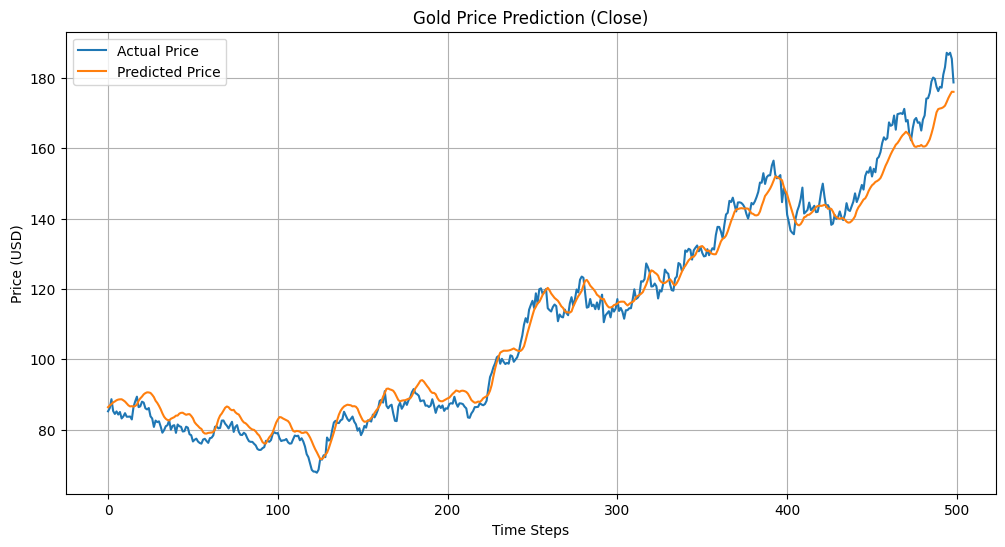

In [26]:

plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Price')
plt.plot(predicted_close, label='Predicted Price')
plt.title('Gold Price Prediction (Close)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [28]:

rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Root Mean Squared Error (RMSE): 4.3748
Mean Absolute Error (MAE): 3.5357
